# Introduction

This notebook is written to demonstrate the use of M3GNet as a structure relaxer as well as to provide more comprehensive benchmarks for cubic crystals based on exp data on Wikipedia and MP DFT data. This benchmark is limited to cubic crystals for ease of comparison since there is only one lattice parameter.

If you are running this notebook from Google Colab, uncomment the next code box to install matgl first.


In [ ]:
# !pip install matgl

In [ ]:
from __future__ import annotations

import os
import warnings

import numpy as np
import pandas as pd
from pymatgen.core import Composition, Lattice, Structure
from pymatgen.ext.matproj import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

import matgl
from matgl.ext.ase import Relaxer

warnings.filterwarnings("ignore")

The next cell just compiles data from Wikipedia.


In [ ]:
data = pd.read_html("http://en.wikipedia.org/wiki/Lattice_constant")[0]
struct_types = [
    "Hexagonal",
    "Wurtzite",
    "Wurtzite (HCP)",
    "Orthorhombic",
    "Tetragonal perovskite",
    "Orthorhombic perovskite",
]
data = data[~data["Crystal structure"].isin(struct_types)]
data = data.rename(columns={"Lattice constant (Å)": "a (Å)"})
data = data.drop(columns=["Ref."])
data["a (Å)"] = data["a (Å)"].map(float)
data = data[["Material", "Crystal structure", "a (Å)"]]


additional_fcc = """10 Ne 4.43 54 Xe 6.20
13 Al 4.05 58 Ce 5.16
18 Ar 5.26 70 Yb 5.49
20 Ca 5.58 77 Ir 3.84
28 Ni 3.52 78 Pt 3.92
29 Cu 3.61 79 Au 4.08
36 Kr 5.72 82 Pb 4.95
38 Sr 6.08 47 Ag 4.09
45 Rh 3.80 89 Ac 5.31
46 Pd 3.89 90 Th 5.08"""

additional_bcc = """3 Li 3.49 42 Mo 3.15
11 Na 4.23 55 Cs 6.05
19 K 5.23 56 Ba 5.02
23 V 3.02 63 Eu 4.61
24 Cr 2.88 73 Ta 3.31
26 Fe 2.87 74 W 3.16
37 Rb 5.59 41 Nb 3.30"""


def add_new(str_, structure_type, df):
    tokens = str_.split()
    new_crystals = []
    for i in range(int(len(tokens) / 3)):
        el = tokens[3 * i + 1].strip()
        if el not in df["Material"].to_numpy():
            new_crystals.append([tokens[3 * i + 1], structure_type, float(tokens[3 * i + 2])])
    df2 = pd.DataFrame(new_crystals, columns=data.columns)
    return pd.concat([df, df2])


data = add_new(additional_fcc, "FCC", data)
data = add_new(additional_bcc, "BCC", data)
data = data[data["Material"] != "NC0.99"]
data = data[data["Material"] != "Xe"]
data = data[data["Material"] != "Kr"]
data = data[data["Material"] != "Rb"]
data = data.set_index("Material")
print(data)

             Crystal structure     a (Å)
Material                                
C (diamond)      Diamond (FCC)  3.567000
Si               Diamond (FCC)  5.431021
Ge               Diamond (FCC)  5.658000
AlAs         Zinc blende (FCC)  5.660500
AlP          Zinc blende (FCC)  5.451000
...                        ...       ...
Cs                         BCC  6.050000
K                          BCC  5.230000
Ba                         BCC  5.020000
Eu                         BCC  4.610000
Cr                         BCC  2.880000

[89 rows x 2 columns]


In the next cell, we generate an initial structure for all the phases. The cubic constant is set to an arbitrary value of 5 angstroms for all structures. It does not matter too much what you set it to, but it cannot be too large or it will result in isolated atoms due to the cutoffs used in m3gnet to determine bonds. We then call the Relaxer, which is the M3GNet universal IAP pre-trained on the Materials Project.


In [ ]:
predicted = []
mp = []
os.environ["MPRESTER_MUTE_PROGRESS_BARS"] = "true"
mpr = MPRester()

# Load the pre-trained M3GNet Potential
pot = matgl.load_model("M3GNet-MP-2021.2.8-PES")

# create the M3GNet Relaxer
relaxer = Relaxer(potential=pot)

for formula, v in data.iterrows():
    formula = formula.split()[0]
    c = Composition(formula)
    els = sorted(c.elements)
    cs = v["Crystal structure"]

    # We initialize all the crystals with an arbitrary lattice constant of 5 angstroms.
    if "Zinc blende" in cs:
        s = Structure.from_spacegroup("F-43m", Lattice.cubic(4.5), [els[0], els[1]], [[0, 0, 0], [0.25, 0.25, 0.75]])
    elif "Halite" in cs:
        s = Structure.from_spacegroup("Fm-3m", Lattice.cubic(4.5), [els[0], els[1]], [[0, 0, 0], [0.5, 0, 0]])
    elif "Caesium chloride" in cs:
        s = Structure.from_spacegroup("Pm-3m", Lattice.cubic(4.5), [els[0], els[1]], [[0, 0, 0], [0.5, 0.5, 0.5]])
    elif "Cubic perovskite" in cs:
        s = Structure(
            Lattice.cubic(5),
            [els[0], els[1], els[2], els[2], els[2]],
            [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, 0], [0.0, 0.5, 0.5], [0.5, 0, 0.5]],
        )
    elif "Diamond" in cs:
        s = Structure.from_spacegroup("Fd-3m", Lattice.cubic(5), [els[0]], [[0.25, 0.75, 0.25]])
    elif "BCC" in cs:
        s = Structure(Lattice.cubic(4.5), [els[0]] * 2, [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]])
    elif "FCC" in cs:
        s = Structure(
            Lattice.cubic(4.5), [els[0]] * 4, [[0.0, 0.0, 0.0], [0.5, 0.5, 0], [0.0, 0.5, 0.5], [0.5, 0, 0.5]]
        )
    else:
        predicted.append(0)
        mp.append(0)
        continue

    # print(s.composition.reduced_formula)
    relax_results = relaxer.relax(s, fmax=0.01)

    final_structure = relax_results["final_structure"]

    predicted.append(final_structure.lattice.a)

    try:
        mids = mpr.get_material_ids(s.composition.reduced_formula)
        for i in mids:
            try:
                structure = mpr.get_structure_by_material_id(i)
                sga = SpacegroupAnalyzer(structure)
                sga2 = SpacegroupAnalyzer(final_structure)
                if sga.get_space_group_number() == sga2.get_space_group_number():
                    conv = sga.get_conventional_standard_structure()
                    mp.append(conv.lattice.a)
                    break
            except Exception:
                pass
        else:
            raise RuntimeError
    except Exception:
        mp.append(0)

data["MP a (Å)"] = mp
data["Predicted a (Å)"] = predicted

In [ ]:
data["% error vs Expt"] = (data["Predicted a (Å)"] - data["a (Å)"]) / data["a (Å)"]
data["% error vs MP"] = (data["Predicted a (Å)"] - data["MP a (Å)"]) / data["MP a (Å)"]

In [ ]:
data.sort_index().style.format({"% error vs Expt": "{:,.2%}", "% error vs MP": "{:,.2%}"}).background_gradient()

,Crystal structure,a (Å),MP a (Å),Predicted a (Å),% error vs Expt,% error vs MP
Material,,,,,,
Ac,FCC,5.310000,5.696211,5.613508,5.72%,-1.45%
Ag,FCC,4.079000,4.104356,4.172203,2.28%,1.65%
Al,FCC,4.046000,4.038930,4.046954,0.02%,0.20%
AlAs,Zinc blende (FCC),5.660500,5.675802,5.730904,1.24%,0.97%
AlP,Zinc blende (FCC),5.451000,5.472967,5.489397,0.70%,0.30%
AlSb,Zinc blende (FCC),6.135500,6.185042,6.228938,1.52%,0.71%
Ar,FCC,5.260000,5.363160,4.145402,-21.19%,-22.71%
Au,FCC,4.065000,4.171289,4.168613,2.55%,-0.06%
BN,Zinc blende (FCC),3.615000,3.626002,3.615134,0.00%,-0.30%


<Axes: >

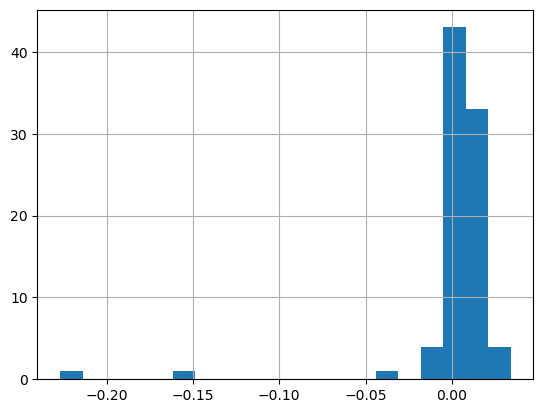

In [ ]:
data["% error vs MP"].replace([np.inf, -np.inf], np.nan).dropna().hist(bins=20)

In [ ]:
# This generates a pretty markdown table output.

# df = data.sort_values("% error vs MP", key=abs).replace([np.inf, -np.inf], np.nan).dropna()
# df["% error vs MP"] = [f"{v*100:.3f}%" for v in df["% error vs MP"]]
# df["% error vs Expt"] = [f"{v*100:.3f}%" for v in df["% error vs Expt"]]
# print(df.to_markdown())